In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm
from sklearn.metrics import roc_auc_score
import matplotlib.pylab as plt

In [2]:
import os
for dirname, _,filenames in os.walk('2003-2023-İşlenmiş.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
df_train = pd.read_csv('train.csv')
df_train.drop('Unnamed: 0', axis=1, inplace = True)
df_train

,Tarih,Açılış,Yüksek,Düşük,Kapanış,Adj Kapanış,Hacim,Haftanın Günü,Ay,Ay Başı,Ay Sonu,H-L
0,1998-01-05,3451.300049,3714.699951,3451.300049,3711.399902,3711.399902,7.303200e+06,1,4,0,0,1
1,1998-01-06,3711.399902,3769.500000,3626.399902,3652.000000,3652.000000,8.050400e+06,4,4,0,0,1
2,1998-01-07,3652.000000,3715.899902,3623.300049,3682.600098,3682.600098,6.260900e+06,5,4,0,0,1
3,1998-01-08,3682.600098,3792.600098,3571.899902,3590.100098,3590.100098,8.944000e+06,3,4,0,0,1
4,1998-01-09,3590.100098,3621.699951,3520.500000,3587.100098,3587.100098,4.521600e+06,0,4,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6456,2022-12-26,5516.899902,5549.399902,5480.500000,5504.100098,5504.100098,3.819828e+09,1,2,0,0,1
6457,2022-12-27,5512.899902,5513.600098,5428.500000,5434.500000,5434.500000,4.017121e+09,4,2,0,0,1
6458,2022-12-28,5443.799805,5450.299805,5258.500000,5345.600098,5345.600098,4.132794e+09,5,2,0,0,1
6459,2022-12-29,5347.700195,5476.899902,5331.799805,5476.899902,5476.899902,3.544420e+09,3,2,0,0,0


In [4]:
var_columns = [c for c in df_train.columns if c not in ['Tarih','H-L']]

X = df_train.loc[:,var_columns]
#print(X)
y = df_train.loc[:,"H-L"]

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size = 0.3, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((4522, 10), (1939, 10), (4522,), (1939,))

In [5]:
train_data = lightgbm.Dataset(X_train, label=y_train)
valid_data = lightgbm.Dataset(X_valid, label=y_valid)

In [6]:
parameters = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': 'true',
              'boosting': 'gbdt',
              'num_leaves': 63,
              'feature_fraction': 0.5,
              'bagging_fraction': 0.5,
              'bagging_freq': 20,
              'learning_rate': 0.01,
              'verbose': -1
             }

c:\Users\Yakup\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

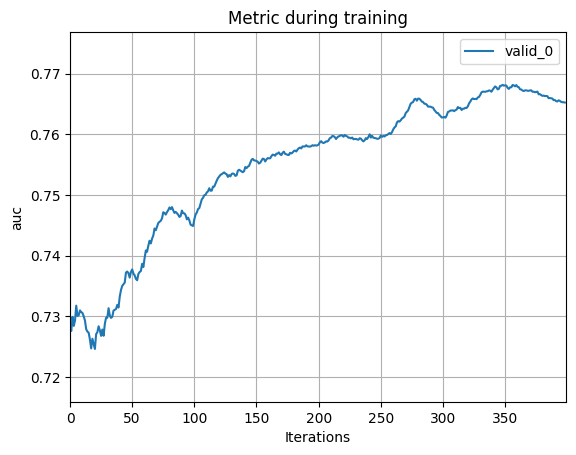

In [7]:
evals={}
model_lgbm = lightgbm.train(parameters,
                            train_data,
                            valid_sets=valid_data,
                            num_boost_round=10000,
                            early_stopping_rounds=50,
                            callbacks = [lightgbm.record_evaluation(evals)])

lightgbm.plot_metric(evals) 

In [8]:
y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_valid, y_valid_pred)))
print(model_lgbm.best_score)   


AUC Train: 0.9771
AUC Valid: 0.7681
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('auc', 0.7681306352669933)])})


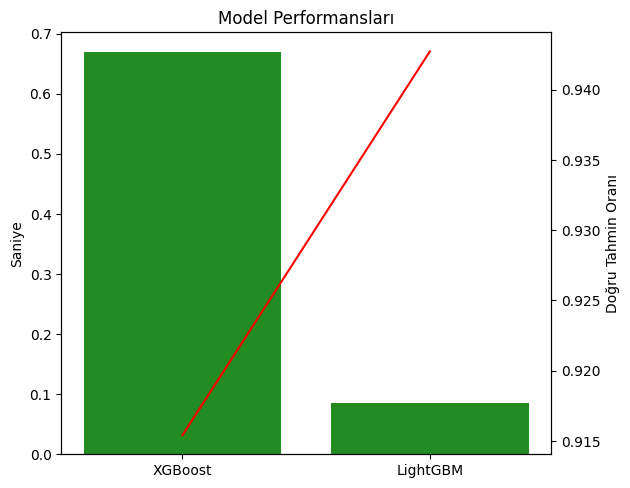

In [9]:
df_test = pd.read_csv('test.csv')
df_sample_submission = pd.read_csv('sample.csv')

from sklearn.metrics import accuracy_score
from time import time
from xgboost import XGBClassifier

t0 = time()
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
XGBoost_time = time() - t0
XGBoost_acc = accuracy_score(y_valid, xgb_model.predict(X_valid))

t0 = time()
lgb_model = lightgbm .LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_time = time() - t0
lgb_acc = accuracy_score(y_train, lgb_model.predict(X_train))

#Doğru Tahmin Oranları ve Eğitim Süreleri Görselleştirilmiştir.
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
objects = ['XGBoost', 'LightGBM']
y_pos = np.arange(len(objects))
performance_time = [XGBoost_time, lgb_time]
performance_acc = [XGBoost_acc, lgb_acc]
ax1.set_ylabel('Saniye')
ax1.bar(y_pos, performance_time, color='forestgreen')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.set_ylabel('Doğru Tahmin Oranı') 
ax2.plot(y_pos, performance_acc, color='red')
plt.xticks(y_pos, objects)
fig.tight_layout() 
plt.title('Model Performansları')
plt.show()

In [10]:
X_test = df_test.loc[:,var_columns]
df_sample_submission['H-L'] = model_lgbm.predict(X_test)
df_sample_submission

,Unnamed: 0,Tarih,Açılış,Yüksek,Düşük,Kapanış,Adj Kapanış,Hacim,Haftanın Günü,Ay,Ay Başı,Ay Sonu,H-L
0,0,1998-01-05,3451.300049,3714.699951,3451.300049,3711.399902,3711.399902,7.303200e+06,1,4,0,0,0.693586
1,1,1998-01-06,3711.399902,3769.500000,3626.399902,3652.000000,3652.000000,8.050400e+06,4,4,0,0,0.864937
2,2,1998-01-07,3652.000000,3715.899902,3623.300049,3682.600098,3682.600098,6.260900e+06,5,4,0,0,0.746984
3,3,1998-01-08,3682.600098,3792.600098,3571.899902,3590.100098,3590.100098,8.944000e+06,3,4,0,0,0.869772
4,4,1998-01-09,3590.100098,3621.699951,3520.500000,3587.100098,3587.100098,4.521600e+06,0,4,0,0,0.613858
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6456,6456,2022-12-26,5516.899902,5549.399902,5480.500000,5504.100098,5504.100098,3.819828e+09,1,2,0,0,0.767267
6457,6457,2022-12-27,5512.899902,5513.600098,5428.500000,5434.500000,5434.500000,4.017121e+09,4,2,0,0,0.687852
6458,6458,2022-12-28,5443.799805,5450.299805,5258.500000,5345.600098,5345.600098,4.132794e+09,5,2,0,0,0.724583
6459,6459,2022-12-29,5347.700195,5476.899902,5331.799805,5476.899902,5476.899902,3.544420e+09,3,2,0,0,0.693910


In [11]:
#df_sample_submission.to_csv("LGM.csv", index=False)
#model_lgbm.save_model('LGMmodel.pkl')

c:\Users\Yakup\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
